In [1053]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

sns.set_style('whitegrid')

#Reading the data
data = pd.read_csv("/Users/rahulkeswani/Downloads/flights_train.csv")
trainingData = data.loc[:, data.columns != 'ARR_DELAY']
targetVariable = data.loc[:, data.columns == 'ARR_DELAY']

testData = pd.read_csv("/Users/rahulkeswani/Downloads/flights_test.csv")
testingData = testData.loc[:, testData.columns != 'ARR_DELAY']
testTargetVariable = testData.loc[:, testData.columns == 'ARR_DELAY']

In [1054]:
len(testingData['UNIQUE_CARRIER'].unique())
len(trainingData['UNIQUE_CARRIER'].unique())

12

<b> DATA UNDERSTANDING </b>

In [1055]:
#Check number of NULL values in every column
trainingData.apply(lambda x: len(trainingData)-x.count(), axis=0)

UID                         0
DAY_OF_WEEK                 0
CRS_DEP_TIME                0
TAXI_OUT                    0
TAXI_IN                     0
ACTUAL_ELAPSED_TIME         0
DISTANCE                    0
DISTANCE_GROUP              0
AIRLINE_ID                  0
FL_DATE                     0
ORIGIN_CITY_MARKET_ID       0
DEST_CITY_MARKET_ID         0
FL_NUM                      0
UNIQUE_CARRIER              0
ORIGIN                      0
ORIGIN_CITY_NAME            0
ORIGIN_STATE_ABR            0
DEST                        0
DEST_CITY_NAME              0
DEST_STATE_ABR              0
FIRST_DEP_TIME           4882
dtype: int64

In [1056]:
#check number of unique values in a column
trainingData.apply(lambda x: len(x.unique()), axis=0)

UID                      4911
DAY_OF_WEEK                 7
CRS_DEP_TIME              814
TAXI_OUT                   75
TAXI_IN                    58
ACTUAL_ELAPSED_TIME       377
DISTANCE                 1020
DISTANCE_GROUP             11
AIRLINE_ID                 12
FL_DATE                   365
ORIGIN_CITY_MARKET_ID     218
DEST_CITY_MARKET_ID       207
FL_NUM                   2967
UNIQUE_CARRIER             12
ORIGIN                    239
ORIGIN_CITY_NAME          235
ORIGIN_STATE_ABR           50
DEST                      228
DEST_CITY_NAME            224
DEST_STATE_ABR             50
FIRST_DEP_TIME             30
dtype: int64

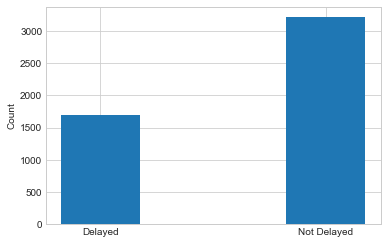

In [1057]:
#Plotting total number of DELAYED and NOT DELAYED flights
delayed = len(targetVariable[targetVariable['ARR_DELAY'] > 0])
notDelayed = len(targetVariable[targetVariable['ARR_DELAY'] <= 0])
y = [delayed, notDelayed]
x = np.arange(len(y))
bar_width = 0.35
plt.bar(x,y,bar_width)
plt.xticks(x, ['Delayed','Not Delayed'])
plt.ylabel('Count')
plt.show()

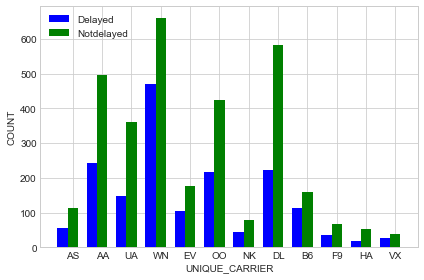

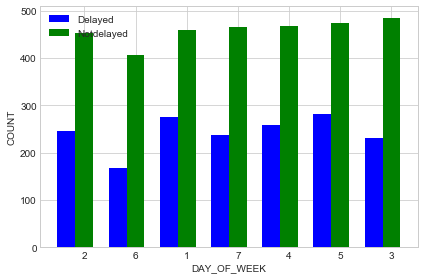

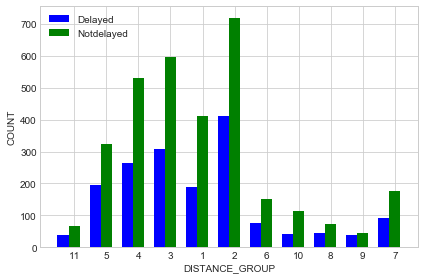

In [1058]:
def plotArr_Delay(data, colName):
    carrierValues = trainingData[colName].unique()
    delayed = []
    notDelayed = []
    for val in carrierValues:
        delayed.append(sum(data[data[colName] == val]['ARR_DELAY'] > 0))
        notDelayed.append(sum(data[data[colName] == val]['ARR_DELAY'] <= 0))
        
    x = np.arange(len(carrierValues))
    bar_width = 0.35

    rect1 = plt.bar(x, delayed, bar_width, color = 'b', label='Delayed')
    rect2 = plt.bar(x+bar_width, notDelayed, bar_width, color = 'g', label='Notdelayed')
    plt.xticks(x+bar_width, carrierValues)
    plt.xlabel(colName)
    plt.ylabel('COUNT')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    
plotArr_Delay(data, 'UNIQUE_CARRIER')
plotArr_Delay(data, 'DAY_OF_WEEK')
plotArr_Delay(data, 'DISTANCE_GROUP')

<b> DATA PRE-PROCESSING </b>

In [1059]:
#Removing the ',' from DISTANCE column
trainingData['DISTANCE'] = trainingData['DISTANCE'].apply(lambda x: x.replace(',',''))
testingData['DISTANCE'] = testingData['DISTANCE'].apply(lambda x: x.replace(',',''))

#Converting DISTANCE column to type numeric from string
trainingData['DISTANCE'] = pd.to_numeric(trainingData.DISTANCE, downcast='signed')
testingData['DISTANCE'] = pd.to_numeric(testingData.DISTANCE, downcast='signed')

#Converting the "FL_DATE" column to Datetime with format YYYY-MM-DD
trainingData['FL_DATE'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in trainingData['FL_DATE']]
testingData['FL_DATE'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in testingData['FL_DATE']]

#Binning the Departure time (CRS_DEP_TIME) into hours
trainingData['CRS_DEP_TIME'] = (trainingData['CRS_DEP_TIME']/100).round()
trainingData['CRS_DEP_TIME'] = pd.to_numeric(trainingData.CRS_DEP_TIME, downcast='signed')

testingData['CRS_DEP_TIME'] = (testingData['CRS_DEP_TIME']/100).round()
testingData['CRS_DEP_TIME'] = pd.to_numeric(testingData.CRS_DEP_TIME, downcast='signed')

#Dropping unnecessary columns 
trainingData = trainingData.drop('AIRLINE_ID', axis = 1) #Because AIRLINE_ID and CARRIER correspond to same value
trainingData = trainingData.drop('FIRST_DEP_TIME', axis = 1) #Because it has 4882 NULL values

testingData = testingData.drop('AIRLINE_ID', axis = 1) #Because AIRLINE_ID and CARRIER correspond to same value
testingData = testingData.drop('FIRST_DEP_TIME', axis = 1) #Because it has 4882 NULL values

/Users/rahulkeswani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/rahulkeswani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/rahulkeswani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

<b> FEATURE EXTRACTION </b>

In [1060]:
#Extracting month from date and adding that as a column
trainingData['MONTH_OF_YEAR'] = trainingData['FL_DATE'].apply(lambda x: x.month)

testingData['MONTH_OF_YEAR'] = testingData['FL_DATE'].apply(lambda x: x.month)

In [1061]:
#Creating a US states and Regions Dictionary
dict = {'AK':'West', 'AL':'South', 'AR':'South', 'AZ':'West', 'CA':'West', 'CO':'West', 'CT':'Northeast', 'DC':'South', 'DE':'South', 'FL':'South', 'GA':'South', 'HI':'West', 'IA':'Midwest', 'ID':'West', 'IL':'Midwest', 'IN':'Midwest', 'KS':'Midwest', 'KY':'South', 'LA':'South', 'MA':'Northeast', 'MD':'South', 'ME':'Northeast', 'MI':'Midwest', 'MN':'Midwest', 'MO':'Midwest', 'MS':'South', 'MT':'West', 'NC':'South', 'ND':'Midwest', 'NE':'Midwest', 'NH':'Northeast', 'NJ':'Northeast', 'NM':'West', 'NV':'West', 'NY':'Northeast', 'OH':'Midwest', 'OK':'South', 'OR':'West', 'PA':'Northeast', 'RI':'Northeast', 'SC':'South', 'SD':'Midwest', 'TN':'South', 'TX':'South', 'UT':'West', 'VA':'South', 'VT':'Northeast', 'WA':'West', 'WI':'Midwest', 'WV':'South', 'WY':'West', 'VI':'South', 'PR':'South'}

#New Dataframe with all the regions
originRegionsDf = pd.DataFrame(columns = ['ORIGIN_REGIONS'])
destRegionsDf = pd.DataFrame(columns = ['DEST_REGIONS'])

#Assigning regions to US states in our training data
for index, eachRow in trainingData.iterrows():
    row = []
    row.append(dict[eachRow['ORIGIN_STATE_ABR']])
    originRegionsDf.loc[len(originRegionsDf)] = row

for index, eachRow in trainingData.iterrows():
    newRow = []
    newRow.append(dict[eachRow['DEST_STATE_ABR']])
    destRegionsDf.loc[len(destRegionsDf)] = newRow
    
#Adding the Regions column to our dataset
trainingData = pd.concat([trainingData, originRegionsDf, destRegionsDf], axis = 1)
trainingData.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,FL_DATE,ORIGIN_CITY_MARKET_ID,...,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,MONTH_OF_YEAR,ORIGIN_REGIONS,DEST_REGIONS
0,0,2,10,11,8,373,2701,11,2017-01-03,30559,...,AS,SEA,"Seattle, WA",WA,LIH,"Lihue, HI",HI,1,West,West
1,1,6,12,13,9,183,1171,5,2017-01-28,33570,...,AA,SAN,"San Diego, CA",CA,DFW,"Dallas/Fort Worth, TX",TX,1,West,South
2,2,6,9,48,6,355,2552,11,2017-01-21,30299,...,AS,ANC,"Anchorage, AK",AK,PHX,"Phoenix, AZ",AZ,1,West,West
3,3,1,14,17,8,136,967,4,2017-01-23,32457,...,UA,SFO,"San Francisco, CA",CA,DEN,"Denver, CO",CO,1,West,West
4,4,1,8,37,7,114,534,3,2017-01-02,30397,...,WN,ATL,"Atlanta, GA",GA,IAD,"Washington, DC",VA,1,South,South


In [1062]:
#Creating a US states and Regions Dictionary
dict = {'AK':'West', 'AL':'South', 'AR':'South', 'AZ':'West', 'CA':'West', 'CO':'West', 'CT':'Northeast', 'DC':'South', 'DE':'South', 'FL':'South', 'GA':'South', 'HI':'West', 'IA':'Midwest', 'ID':'West', 'IL':'Midwest', 'IN':'Midwest', 'KS':'Midwest', 'KY':'South', 'LA':'South', 'MA':'Northeast', 'MD':'South', 'ME':'Northeast', 'MI':'Midwest', 'MN':'Midwest', 'MO':'Midwest', 'MS':'South', 'MT':'West', 'NC':'South', 'ND':'Midwest', 'NE':'Midwest', 'NH':'Northeast', 'NJ':'Northeast', 'NM':'West', 'NV':'West', 'NY':'Northeast', 'OH':'Midwest', 'OK':'South', 'OR':'West', 'PA':'Northeast', 'RI':'Northeast', 'SC':'South', 'SD':'Midwest', 'TN':'South', 'TX':'South', 'UT':'West', 'VA':'South', 'VT':'Northeast', 'WA':'West', 'WI':'Midwest', 'WV':'South', 'WY':'West', 'VI':'South', 'PR':'South'}

#New Dataframe with all the regions
testoriginRegionsDf = pd.DataFrame(columns = ['ORIGIN_REGIONS'])
testdestRegionsDf = pd.DataFrame(columns = ['DEST_REGIONS'])

#Assigning regions to US states in our training data
for index, eachRow in testingData.iterrows():
    row = []
    row.append(dict[eachRow['ORIGIN_STATE_ABR']])
    testoriginRegionsDf.loc[len(testoriginRegionsDf)] = row

for index, eachRow in testingData.iterrows():
    newRow = []
    newRow.append(dict[eachRow['DEST_STATE_ABR']])
    testdestRegionsDf.loc[len(testdestRegionsDf)] = newRow
    
#Adding the Regions column to our dataset
testingData = pd.concat([testingData, testoriginRegionsDf, testdestRegionsDf], axis = 1)
testingData.head()

,UID,DAY_OF_WEEK,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,FL_DATE,ORIGIN_CITY_MARKET_ID,...,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,MONTH_OF_YEAR,ORIGIN_REGIONS,DEST_REGIONS
0,8,3,20,18,5,83,337,2,2017-01-25,32575,...,OO,LAX,"Los Angeles, CA",CA,SFO,"San Francisco, CA",CA,1,West,West
1,15,2,18,12,4,182,1476,6,2017-01-10,32457,...,WN,SJC,"San Jose, CA",CA,AUS,"Austin, TX",TX,1,West,South
2,29,2,15,17,4,138,780,4,2017-01-17,31703,...,EV,HPN,"White Plains, NY",NY,ATL,"Atlanta, GA",GA,1,Northeast,South
3,33,1,9,10,2,116,773,4,2017-01-09,33105,...,DL,CVG,"Cincinnati, OH",KY,TPA,"Tampa, FL",FL,1,South,South
4,65,6,14,19,5,278,2419,10,2017-01-07,32457,...,VX,SFO,"San Francisco, CA",CA,IAD,"Washington, DC",VA,1,West,South


In [1063]:
#Function for performing One Hot Encoding
def performOneHotEncoding(trainingData, colValues, colName):
    tempData = pd.get_dummies(colValues)
    uniqueValues = tempData.columns.values
    colHeaders = []
    for val in uniqueValues:
        colHeaders.append(colName+"_"+str(val))
    tempData.columns = colHeaders
    return trainingData.join(tempData)

#Perform One Hot Encoding
trainingData = performOneHotEncoding(trainingData, trainingData.DAY_OF_WEEK, 'DAY_OF_WEEK')
trainingData = performOneHotEncoding(trainingData, trainingData.UNIQUE_CARRIER, 'UNIQUE_CARRIER')
trainingData = performOneHotEncoding(trainingData, trainingData.ORIGIN_REGIONS, 'ORIGIN_REGIONS')
trainingData = performOneHotEncoding(trainingData, trainingData.DEST_REGIONS, 'DEST_REGIONS')
trainingData = performOneHotEncoding(trainingData, trainingData.MONTH_OF_YEAR, 'MONTH_OF_YEAR')
# trainingData = performOneHotEncoding(trainingData, trainingData.CRS_DEP_TIME, 'CRS_DEP_TIME')

testingData = performOneHotEncoding(testingData, testingData.DAY_OF_WEEK, 'DAY_OF_WEEK')
testingData = performOneHotEncoding(testingData, testingData.UNIQUE_CARRIER, 'UNIQUE_CARRIER')
testingData = performOneHotEncoding(testingData, testingData.ORIGIN_REGIONS, 'ORIGIN_REGIONS')
testingData = performOneHotEncoding(testingData, testingData.DEST_REGIONS, 'DEST_REGIONS')
testingData = performOneHotEncoding(testingData, testingData.MONTH_OF_YEAR, 'MONTH_OF_YEAR')
# testingData = performOneHotEncoding(testingData, testingData.CRS_DEP_TIME, 'CRS_DEP_TIME')

In [1064]:
#Function for calculating closest Number of days to a holiday for each of the 365 days
def calculateDaysToHoliday(month, day):
    year = 2017
    numDays = []
    numDays = [datetime.date(year,month,day) - date for date in holidays]
    daysDifference = []
    for i in range(0,len(numDays)):
        daysDifference.append(abs(numDays[i].days))
    return min(daysDifference)

#Specifying the holiday dates in the US for the year 2017
dates = ['2017-01-02','2017-01-16','2017-02-20','2017-04-17','2017-05-14','2017-05-29','2017-06-18','2017-07-04',
           '2017-09-04','2017-10-09','2017-11-10','2017-11-11','2017-11-13','2017-11-23','2017-11-24','2017-12-25']

#Converting the holiday dates to Date format
holidays = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

#Finding all the unique dates from "FL_DATE" column and calling the calculateDaysToHoliday() function for each of them
datesOfYear = trainingData['FL_DATE'].unique()
datesOfYear = pd.to_datetime(datesOfYear)
difference = [calculateDaysToHoliday(date.month, date.day) for date in datesOfYear]
dateDifference = pd.concat([pd.DataFrame(datesOfYear.month), pd.DataFrame(datesOfYear.day), pd.DataFrame(difference)], axis=1)
dateDifference.columns = ['Month','Day','Difference']

#Mapping every value in FL_DATE column to its corresponding closest number of Days to Holiday by appending a column
DAYS_TO_HOLIDAY = []
count = 0
for i in range(0,len(trainingData)):
    DAYS_TO_HOLIDAY.append(int((dateDifference['Difference'][(dateDifference['Month'] == trainingData['FL_DATE'][i].month) & 
                             (dateDifference['Day'] == trainingData['FL_DATE'][i].day)]).values))
trainingData = pd.concat([trainingData, pd.DataFrame(DAYS_TO_HOLIDAY)], axis=1)
trainingData.rename(columns={0:'DAYS_TO_HOLIDAY'}, inplace=True)

In [1065]:
#Finding all the unique dates from "FL_DATE" column and calling the calculateDaysToHoliday() function for each of them
datesOfYear = testingData['FL_DATE'].unique()
datesOfYear = pd.to_datetime(datesOfYear)
difference = [calculateDaysToHoliday(date.month, date.day) for date in datesOfYear]
dateDifference = pd.concat([pd.DataFrame(datesOfYear.month), pd.DataFrame(datesOfYear.day), pd.DataFrame(difference)], axis=1)
dateDifference.columns = ['Month','Day','Difference']

#Mapping every value in FL_DATE column to its corresponding closest number of Days to Holiday by appending a column
DAYS_TO_HOLIDAY = []
count = 0
for i in range(0,len(testingData)):
    DAYS_TO_HOLIDAY.append(int((dateDifference['Difference'][(dateDifference['Month'] == testingData['FL_DATE'][i].month) & 
                             (dateDifference['Day'] == testingData['FL_DATE'][i].day)]).values))
testingData = pd.concat([testingData, pd.DataFrame(DAYS_TO_HOLIDAY)], axis=1)
testingData.rename(columns={0:'DAYS_TO_HOLIDAY'}, inplace=True)

In [1066]:
newNumericalAttributes = trainingData._get_numeric_data().columns

trainingData2 = pd.DataFrame()
for attr in newNumericalAttributes:
    trainingData2 = pd.concat([trainingData2, pd.DataFrame(trainingData[attr])], axis = 1)
trainingData2 = trainingData2.drop(['UID','DAY_OF_WEEK','ORIGIN_CITY_MARKET_ID','DISTANCE','DISTANCE_GROUP','DEST_CITY_MARKET_ID','FL_NUM'], axis=1)

trainingData2.head()

,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,MONTH_OF_YEAR,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,...,MONTH_OF_YEAR_4,MONTH_OF_YEAR_5,MONTH_OF_YEAR_6,MONTH_OF_YEAR_7,MONTH_OF_YEAR_8,MONTH_OF_YEAR_9,MONTH_OF_YEAR_10,MONTH_OF_YEAR_11,MONTH_OF_YEAR_12,DAYS_TO_HOLIDAY
0,10,11,8,373,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,12,13,9,183,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
2,9,48,6,355,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,14,17,8,136,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,8,37,7,114,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1067]:
newNumericalAttributes1 = testingData._get_numeric_data().columns

testingData2 = pd.DataFrame()
for attr in newNumericalAttributes1:
    testingData2 = pd.concat([testingData2, pd.DataFrame(testingData[attr])], axis = 1)
testingData2 = testingData2.drop(['UID','DAY_OF_WEEK','ORIGIN_CITY_MARKET_ID','DISTANCE','DISTANCE_GROUP','DEST_CITY_MARKET_ID','FL_NUM'], axis=1)
testingData2.head()
# testingData = testingData.drop(['UID','DAY_OF_WEEK','UNIQUE_CARRIER','ORIGIN','ORIGIN_CITY_NAME','ORIGIN_STATE_ABR','ORIGIN_REGIONS','DEST_REGIONS','DEST_CITY_NAME','DEST','DEST_STATE_ABR','ORIGIN_CITY_MARKET_ID','DISTANCE','DISTANCE_GROUP','DEST_CITY_MARKET_ID','FL_NUM'], axis=1)

,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,ACTUAL_ELAPSED_TIME,MONTH_OF_YEAR,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,...,MONTH_OF_YEAR_4,MONTH_OF_YEAR_5,MONTH_OF_YEAR_6,MONTH_OF_YEAR_7,MONTH_OF_YEAR_8,MONTH_OF_YEAR_9,MONTH_OF_YEAR_10,MONTH_OF_YEAR_11,MONTH_OF_YEAR_12,DAYS_TO_HOLIDAY
0,20,18,5,83,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,9
1,18,12,4,182,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,15,17,4,138,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,9,10,2,116,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,14,19,5,278,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [1068]:
#Function to split the data into Train and Test set
def performTrainTestSplit(trainingData, targetVariable):
    independentVariablesTrain, independentVariablesTest, targetVariableTrain, targetVariableTest = train_test_split(trainingData, targetVariable, test_size=0.33, random_state=42)
        
    #return trainLinearRegressionModel(independentVariablesTrain, targetVariableTrain, independentVariablesTest, targetVariableTest)
    return independentVariablesTrain, targetVariableTrain, independentVariablesTest, targetVariableTest
    
#Function to train Linear Regression Model
def trainLinearRegressionModel(xTrain, yTrain, xTest, yTest):
    model = linear_model.LinearRegression()
    model.fit(xTrain, yTrain)
    predictedDelay = model.predict(xTest)
    
    return predictedDelay

def randomForest(xTrain, yTrain, xTest, yTest):
    randomForest = RandomForestRegressor()
    randomForest.fit(xTrain, yTrain)
    predicted = randomForest.predict(xTest)
    return measureAccuracy(yTest, predicted)

def performDT(xTrain, yTrain, xTest, yTest):
    regression_tree = tree.DecisionTreeRegressor(max_depth=3, min_samples_leaf=25, random_state=0)  #(min_samples_leaf = 200, random_state=0)
    DTmodel = regression_tree.fit(xTrain,yTrain)
    predicted = DTmodel.predict(xTest)
    return measureAccuracy(yTest, predicted)

def performKFold(trainingData2, targetVariable):
    errList = []
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(trainingData2):
        xTrain, xTest = trainingData2[train_index], targetVariable[test_index]
        yTrain, yTest = trainingData2[train_index], targetVariable[test_index]
        errList.append(performDT(xTrain, yTrain, xTest, yTest))
    return errList

#Function to measure the Root Mean Sqaured Error for the model
def measureAccuracy(yTest, predictedDelay):
    return np.sqrt(mean_squared_error(yTest, predictedDelay)) #r2_score(yTest, predictedDelay)

In [1070]:
xTrain, yTrain, xTest, yTest = performTrainTestSplit(trainingData2, targetVariable)
err = trainLinearRegressionModel(xTrain, yTrain, xTest, yTest)

print("RMSE :",err)

RMSE : [[ -2.4074707 ]
 [ 25.17041016]
 [  6.56665039]
 ..., 
 [ -3.14477539]
 [ -0.82836914]
 [  1.88256836]]


In [1071]:
xTrain, yTrain, xTest, yTest = performTrainTestSplit(trainingData2, targetVariable)
err = performDT(xTrain, yTrain, xTest, yTest)

print("RMSE :",err)

RMSE : 45.3203293993


In [1072]:
# xTrain, yTrain, xTest, yTest = performTrainTestSplit(testingData, targetVariable)
predicted = trainLinearRegressionModel(trainingData2, targetVariable, testingData2, yTest)

predictionsDF = pd.DataFrame(predicted)
# predictionsDF


In [1073]:
predictionsDF.columns = ['Arr_Delay']
testData['Arr_Delay'] = predictionsDF.Arr_Delay.apply(lambda x : str(x))
testData.to_csv("flights_test_predicted.csv", sep=',')